<a href="https://colab.research.google.com/github/nbilasals/indonesia_salary_forecast/blob/main/ump_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Regional Salaries (UMR) in Indonesia Using Time Series

## Project Domain

This project focuses on forecasting regional salaries in Indonesia using time series analysis. Regional salary data is important to monitor as it reflects the economic conditions of different regions and helps policymakers, businesses, and job seekers make informed decisions.

The problem arises from the lack of accessible and reliable salary forecasts, which are critical for planning workforce strategies and improving economic policies.

**Why Solve This Problem?**
1. Salary forecasting helps businesses plan recruitment budgets.
2. Policymakers can use the forecasted data to address economic gaps between regions.
3. Forecasting can help job seekers understand future trends and improve financial planning.

## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from google.colab import files
import os
import shutil
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

## Data Preparation

### Data Loading

In [2]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
shutil.move('kaggle.json', '~/.kaggle/kaggle.json')
!chmod 600 ~/.kaggle/kaggle.json

FileNotFoundError: [Errno 2] No such file or directory: '~/.kaggle/kaggle.json'

In [4]:
!kaggle datasets download -d linkgish/indonesian-salary-by-region-19972022

Dataset URL: https://www.kaggle.com/datasets/linkgish/indonesian-salary-by-region-19972022
License(s): GPL-2.0
  0% 0.00/5.08k [00:00<?, ?B/s]
100% 5.08k/5.08k [00:00<00:00, 11.2MB/s]


In [126]:
!unzip indonesian-salary-by-region-19972022.zip

Archive:  indonesian-salary-by-region-19972022.zip
replace Indonesian Salary by Region (1997-2022).csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Indonesian Salary by Region (1997-2022).csv  


In [147]:
df = pd.read_csv("Indonesian Salary by Region (1997-2022).csv")
df

,REGION,SALARY,YEAR
0,ACEH,128000,1997
1,SUMATERA UTARA,151000,1997
2,SUMATERA BARAT,119000,1997
3,RIAU,151500,1997
4,JAMBI,119500,1997
...,...,...,...
865,MALUKU,2619312,2022
866,MALUKU UTARA,2862231,2022
867,PAPUA BARAT,3200000,2022
868,PAPUA,3561932,2022


In [148]:
df['REGION'] = df['REGION'].str.title()
df

,REGION,SALARY,YEAR
0,Aceh,128000,1997
1,Sumatera Utara,151000,1997
2,Sumatera Barat,119000,1997
3,Riau,151500,1997
4,Jambi,119500,1997
...,...,...,...
865,Maluku,2619312,2022
866,Maluku Utara,2862231,2022
867,Papua Barat,3200000,2022
868,Papua,3561932,2022


In [149]:
# Drop rows where the 'REGION' column is 'Indonesia'
df = df[df['REGION'] != 'Indonesia']
df

,REGION,SALARY,YEAR
0,Aceh,128000,1997
1,Sumatera Utara,151000,1997
2,Sumatera Barat,119000,1997
3,Riau,151500,1997
4,Jambi,119500,1997
...,...,...,...
864,Sulawesi Barat,2678863,2022
865,Maluku,2619312,2022
866,Maluku Utara,2862231,2022
867,Papua Barat,3200000,2022


In [150]:
unique_regions = df['REGION'].unique()
unique_regions

array(['Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi',
       'Sumatera Selatan', 'Bengkulu', 'Lampung', 'Kep. Riau',
       'Dki Jakarta', 'Jawa Barat', 'Jawa Tengah', 'Di Yogyakarta',
       'Jawa Timur', 'Bali', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Kalimantan Barat', 'Kalimantan Tengah', 'Kalimantan Selatan',
       'Kalimantan Timur', 'Sulawesi Utara', 'Sulawesi Tengah',
       'Sulawesi Selatan', 'Sulawesi Tenggara', 'Maluku', 'Papua',
       'Kep. Bangka Belitung', 'Banten', 'Gorontalo', 'Maluku Utara',
       'Sulawesi Barat', 'Papua Barat', 'Kalimantan Utara'], dtype=object)

In [151]:
import pandas as pd

# Your salary data
salary_2023_data = {
    "REGION": [
        "Aceh", "Sumatera Utara", "Sumatera Barat", "Kep. Riau", "Kep. Bangka Belitung", "Riau", "Bengkulu",
        "Sumatera Selatan", "Jambi", "Lampung", "Banten", "Dki Jakarta", "Jawa Barat", "Jawa Tengah",
        "Di Yogyakarta", "Jawa Timur", "Bali", "Nusa Tenggara Barat", "Nusa Tenggara Timur",
        "Kalimantan Barat", "Kalimantan Tengah", "Kalimantan Selatan", "Kalimantan Timur", "Kalimantan Utara",
        "Sulawesi Tengah", "Sulawesi Tenggara", "Sulawesi Utara", "Sulawesi Selatan", "Gorontalo", "Sulawesi Barat",
        "Maluku", "Maluku Utara", "Papua", "Papua Barat", "Papua Tengah", "Papua Pegunungan", "Papua Barat Daya",
        "Papua Selatan"
    ],
    "2023_Salary": [
        3413666, 2710493, 2742476, 3279194, 3498479, 3191662, 2418280, 3404177, 2943000, 2633284,
        2661280, 4900798, 1986670, 1958169, 1981782, 2040244, 2713672, 2371407, 2123994, 2608601,
        3181013, 3149977, 3201396, 3251702, 2599546, 2758984, 3485000, 3385145, 2989350, 2871794,
        2812827, 2976720, 3864696, 3282000, 3864700, 3864696, 3864696, 3864696
    ]
}

salary_2024_data = {
    "REGION": [
        "Aceh", "Sumatera Utara", "Sumatera Barat", "Kep. Riau", "Kep. Bangka Belitung", "Riau", "Bengkulu",
        "Sumatera Selatan", "Jambi", "Lampung", "Banten", "Dki Jakarta", "Jawa Barat", "Jawa Tengah",
        "Di Yogyakarta", "Jawa Timur", "Bali", "Nusa Tenggara Barat", "Nusa Tenggara Timur",
        "Kalimantan Barat", "Kalimantan Tengah", "Kalimantan Selatan", "Kalimantan Timur", "Kalimantan Utara",
        "Sulawesi Tengah", "Sulawesi Tenggara", "Sulawesi Utara", "Sulawesi Selatan", "Gorontalo", "Sulawesi Barat",
        "Maluku", "Maluku Utara", "Papua", "Papua Barat", "Papua Tengah", "Papua Pegunungan", "Papua Barat Daya",
        "Papua Selatan"
    ],
    "2024_Salary": [
        3460672, 2809915, 2811449, 3402492, 3640000, 3294625, 2507079, 3456874, 3037121, 2716497,
        2727812, 5067381, 2057495, 2036947, 2125897, 2165244, 2813672, 2444067, 2186826, 2702616,
        3261616, 3282812, 3360858, 3361653, 2736698, 2885964, 3545000, 3434298, 3025100, 2914958,
        2949953, 3200000, 4024270, 3393000, 4024270, 4024270, 4024270, 4024270
    ]
}

# Create DataFrames
df_salary_2023 = pd.DataFrame(salary_2023_data)
df_salary_2024 = pd.DataFrame(salary_2024_data)

# Merge the 2023 and 2024 salary DataFrames
df_merged = pd.merge(df_salary_2023, df_salary_2024, on="REGION", how="left")

# Melt the DataFrame to have the salary columns in one column
df_merged = pd.melt(df_merged, id_vars=["REGION"], value_vars=["2023_Salary", "2024_Salary"],
                    var_name="YEAR", value_name="SALARY")

# Clean up the 'YEAR' column to extract just the year number (remove '_Salary' part)
df_merged['YEAR'] = df_merged['YEAR'].apply(lambda x: x.split("_")[0])
df_merged

,REGION,YEAR,SALARY
0,Aceh,2023,3413666
1,Sumatera Utara,2023,2710493
2,Sumatera Barat,2023,2742476
3,Kep. Riau,2023,3279194
4,Kep. Bangka Belitung,2023,3498479
...,...,...,...
71,Papua Barat,2024,3393000
72,Papua Tengah,2024,4024270
73,Papua Pegunungan,2024,4024270
74,Papua Barat Daya,2024,4024270


In [152]:
# If df already exists and has similar columns (like Region, Year, Salary), ensure no conflict
# Example: If df already has data, merge it into df_merged
df = pd.concat([df, df_merged], ignore_index=True)

# Optionally sort by Region and Year for organization
df = df.sort_values(by=['REGION', 'YEAR']).reset_index(drop=True)

# Display the final DataFrame
df

,REGION,SALARY,YEAR
0,Aceh,128000,1997
1,Aceh,147000,1998
2,Aceh,171000,1999
3,Aceh,265000,2000
4,Aceh,300000,2001
...,...,...,...
915,Sumatera Utara,2499423,2020
916,Sumatera Utara,2499423,2021
917,Sumatera Utara,2522609,2022
918,Sumatera Utara,2710493,2023


In [153]:
df.to_csv('salary_indo_19972024.csv', index=False)

### Exploratory Data Analysis

In [154]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   REGION  920 non-null    object
 1   SALARY  920 non-null    int64 
 2   YEAR    920 non-null    object
dtypes: int64(1), object(2)
memory usage: 21.7+ KB


In [155]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
SALARY,920.0,1.337366e+06,1.040074e+06,106000.0,447838.5,987000.0,2136641.75,5067381.0


In [156]:
# Average salary per region
region_salary = df.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)
region_salary

,SALARY
REGION,
Papua Tengah,3.944485e+06
Papua Selatan,3.944483e+06
Papua Barat Daya,3.944483e+06
Papua Pegunungan,3.944483e+06
Kalimantan Utara,2.751733e+06
Papua Barat,2.114187e+06
Dki Jakarta,2.004255e+06
Papua,1.713855e+06
Sulawesi Barat,1.713196e+06


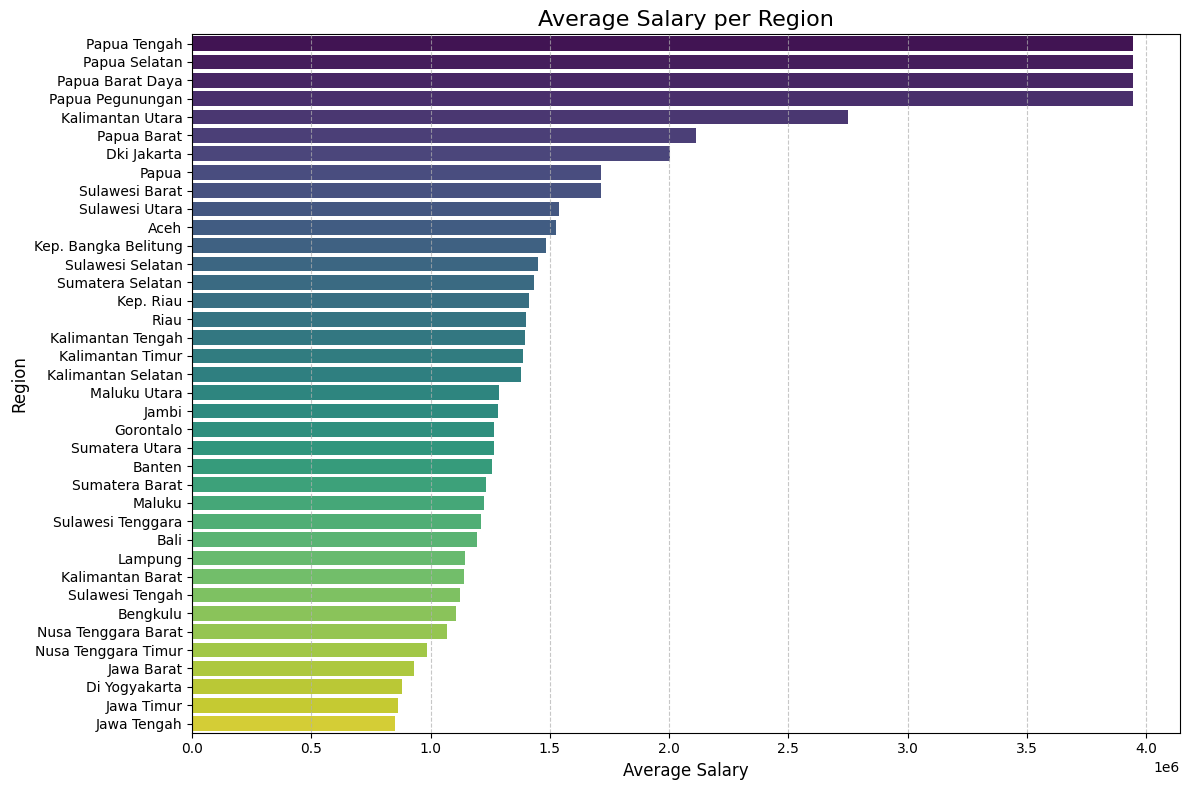

In [157]:
# Average salary per region visualization
plt.figure(figsize=(12, 8))
sns.barplot(x=region_salary.values, y=region_salary.index, palette="viridis")

# Adding labels and title
plt.title('Average Salary per Region', fontsize=16)
plt.xlabel('Average Salary', fontsize=12)
plt.ylabel('Region', fontsize=12)

# Improve readability with grid
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [158]:
# Yearly trends
yearly_trend = df.groupby('YEAR')['SALARY'].mean()
yearly_trend

,SALARY
YEAR,
1997,1.349630e+05
1998,1.509387e+05
1999,1.753903e+05
2000,2.165065e+05
2001,2.904871e+05
2002,3.646419e+05
2003,4.149355e+05
2004,4.573097e+05
2005,5.076968e+05


<Figure size 1000x600 with 0 Axes>

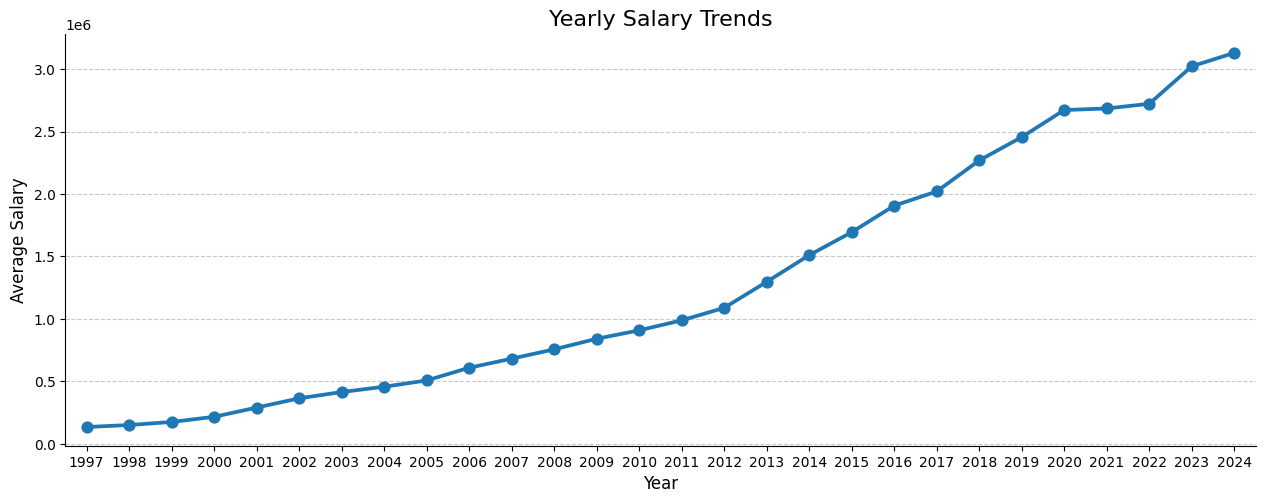

In [159]:
# Yearly trend
plt.figure(figsize=(10, 6))
sns.catplot(x=yearly_trend.index, y=yearly_trend.values, marker='o',kind='point',aspect=2.5)

# Adding labels and title
plt.title('Yearly Salary Trends', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)

# Improve readability with grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [160]:
# Calculate salary growth of country by year

# Calculate the average salary per year for the entire country
avg = df.groupby('YEAR', as_index=False)['SALARY'].mean()

# Calculate yearly salary growth
avg['growth'] = avg['SALARY'].diff()  # Year-to-year growth
avg

,YEAR,SALARY,growth
0,1997,1.349630e+05,NaN
1,1998,1.509387e+05,15975.746714
2,1999,1.753903e+05,24451.612903
3,2000,2.165065e+05,41116.129032
4,2001,2.904871e+05,73980.645161
5,2002,3.646419e+05,74154.838710
6,2003,4.149355e+05,50293.548387
7,2004,4.573097e+05,42374.193548
8,2005,5.076968e+05,50387.129032
9,2006,6.093625e+05,101665.648094


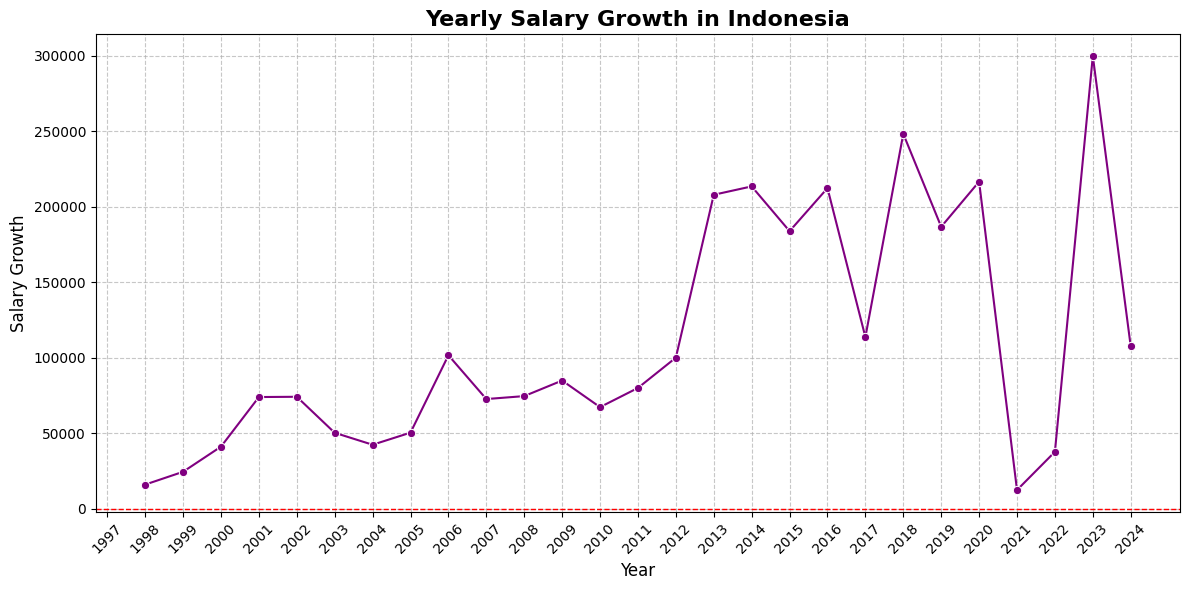

In [161]:
# Plotting salary growth
plt.figure(figsize=(12, 6))
sns.lineplot(data=avg, x='YEAR', y='growth', marker='o', color='purple')

# Adding labels and title
plt.title('Yearly Salary Growth in Indonesia', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Salary Growth', fontsize=12)

# Adding gridlines for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)

# Highlight zero growth line
plt.axhline(0, color='red', linestyle='--', linewidth=1)

# Customize tick parameters
# Convert 'YEAR' column to numeric
# This assumes 'YEAR' contains values that can be converted to integers
avg['YEAR'] = pd.to_numeric(avg['YEAR'])
plt.xticks(avg['YEAR'], rotation=45, fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()

From the chart above, we can see that 2018 had the highest average UMP (Provincial Minimum Wage) in the observed period, followed by 2020 and 2014. On the other hand, the lowest UMP values occurred in 2021, with 1998 and 1999 not far behind. This sharp decline in 2021 can likely be attributed to the economic impacts of the COVID-19 pandemic, which disrupted labor markets and led to wage stagnation. Similarly, the dip in 1998 and 1999 corresponds with the financial crisis that severely affected Indonesia's economy, pushing wages to their lowest point in recent history. These events highlight how external factors, such as global pandemics and financial crises, can deeply influence regional wage trends.

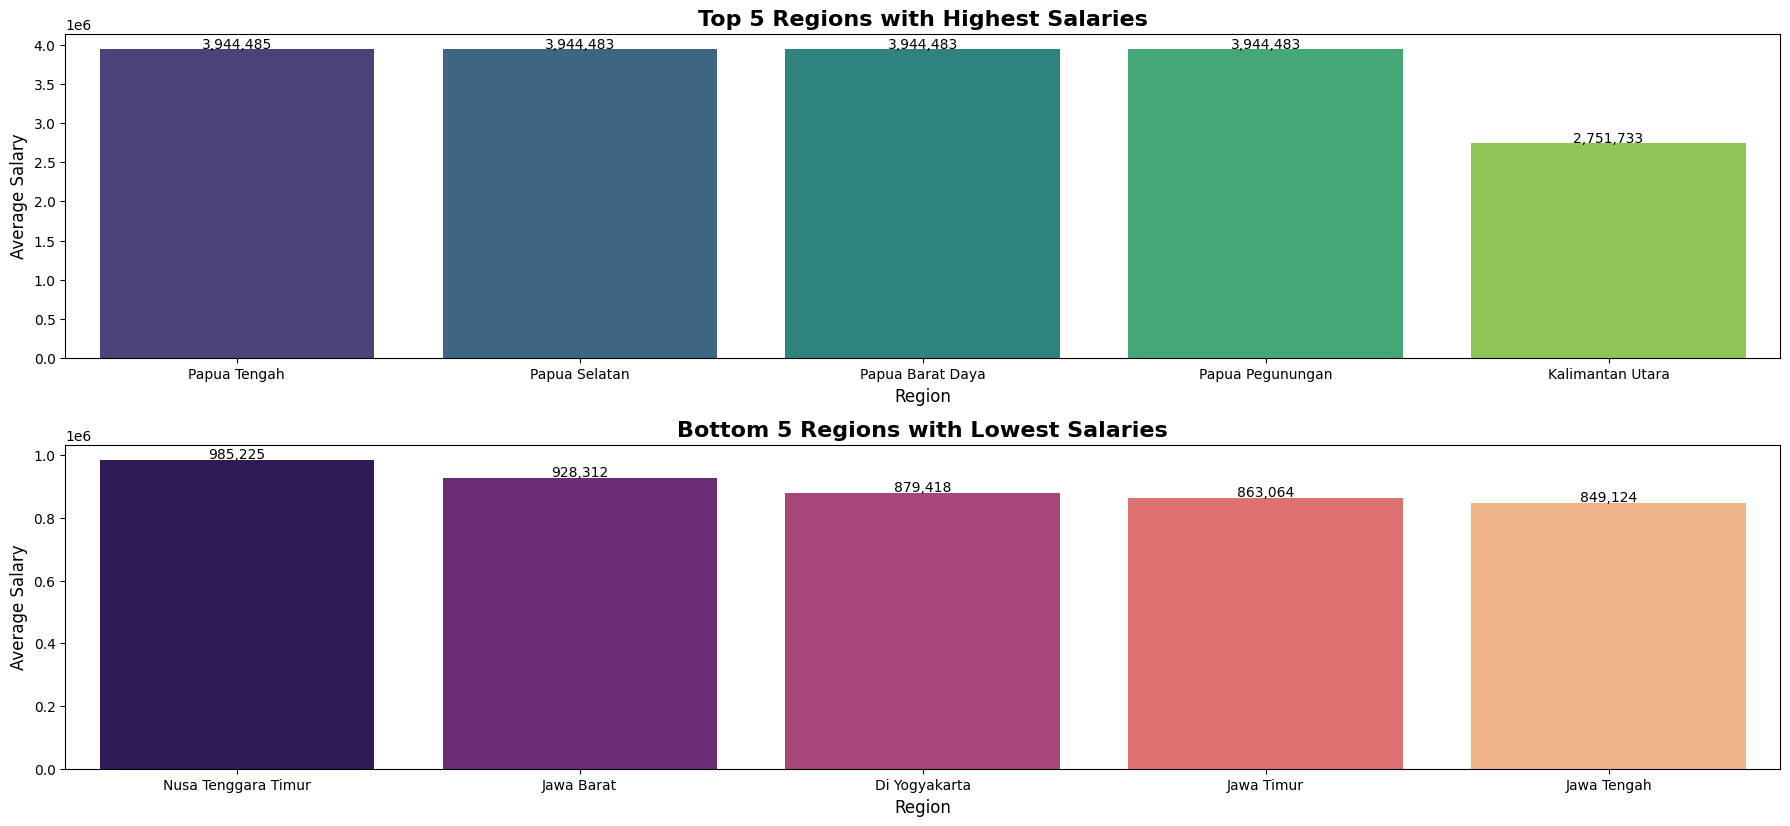

In [162]:
# Calculate the average salary per region
region_salary = df.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)

# Get top 5 and bottom 5 regions
top_5_regions = region_salary.head(5)
bottom_5_regions = region_salary.tail(5)

# Full chart data
sorted_regions = region_salary.reset_index()

# Plotting
plt.figure(figsize=(18, 12))

# Subplot 1: Top 5 regions
plt.subplot(3, 1, 1)
sns.barplot(x=top_5_regions.index, y=top_5_regions.values, palette='viridis')
plt.title('Top 5 Regions with Highest Salaries', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(top_5_regions.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

# Subplot 2: Bottom 5 regions
plt.subplot(3, 1, 2)
sns.barplot(x=bottom_5_regions.index, y=bottom_5_regions.values, palette='magma')
plt.title('Bottom 5 Regions with Lowest Salaries', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(bottom_5_regions.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

From 1997 to 2015, there were province expansions, and the minimum wage (UMR) data for each year was inconsistent, which makes it irrelevant for analysis.

To obtain accurate and relevant results in the minimum wage (UMR) calculation, we will focus on data from the last 7 years, which is from 2017 to 2024. During this period, the minimum wage (UMR) figures for each year are consistent, and this will serve as the basis for the most current and relevant minimum wage analysis.

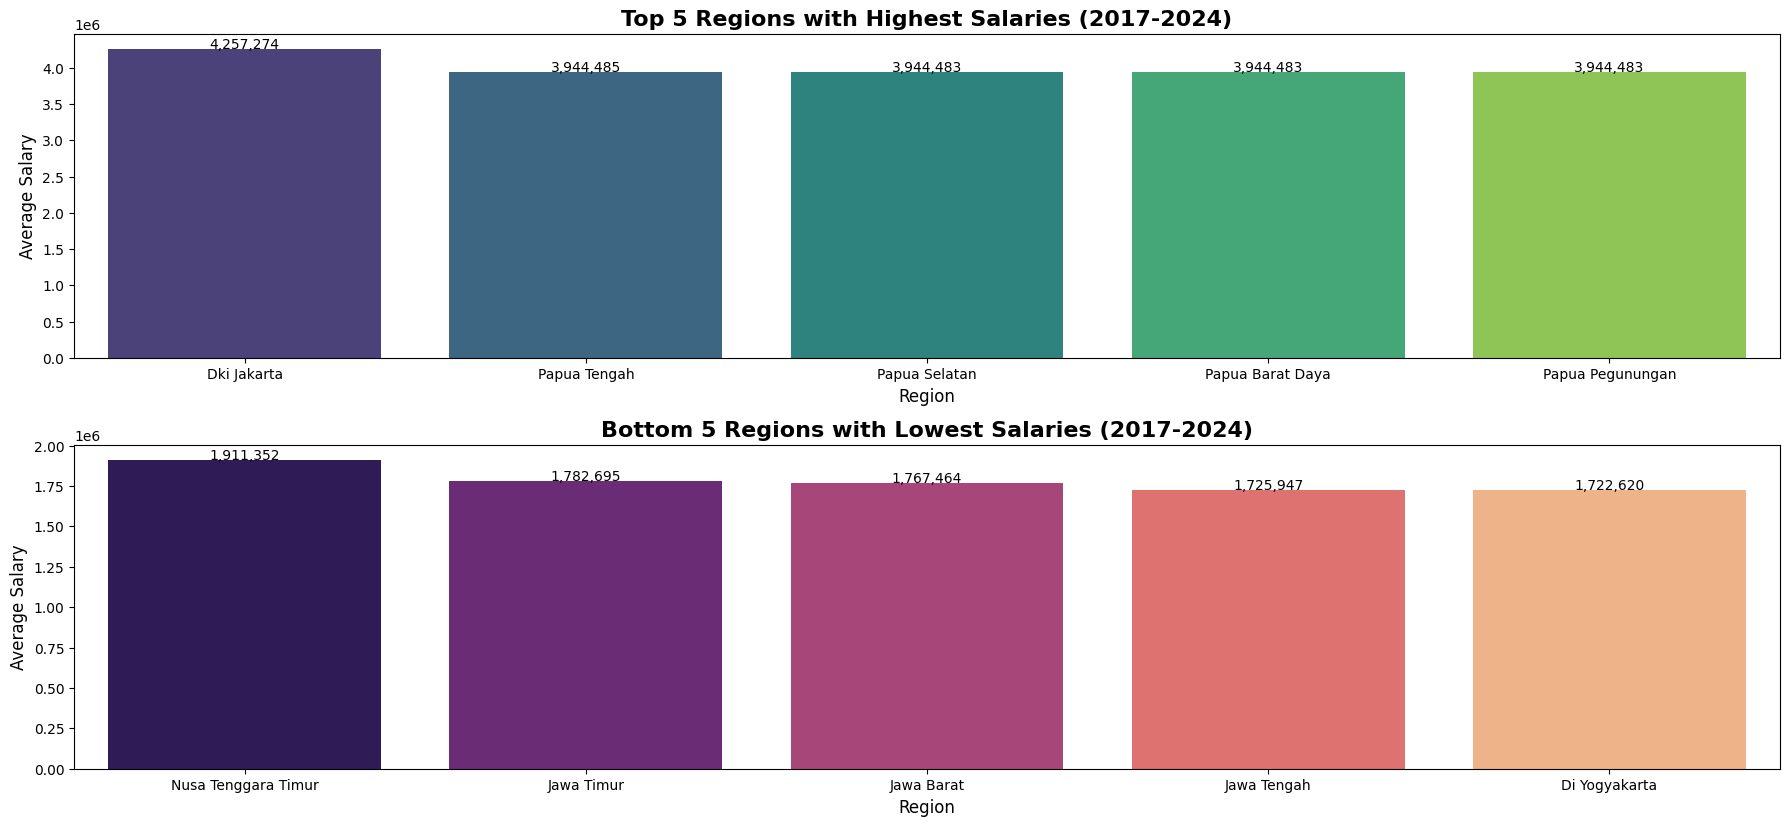

In [183]:
# Filter data for the year above 2017
df_filtered = df[(df['YEAR'].astype(int) >= 2017)]

# Calculate the average salary per region for 2022
region_salary_2024 = df_filtered.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)

# Get top 5 and bottom 5 regions
top_5_regions_2024 = region_salary_2024.head(5)
bottom_5_regions_2024 = region_salary_2024.tail(5)

# Full chart data (sorted)
sorted_regions_2024 = region_salary_2024.reset_index()

# Plotting
plt.figure(figsize=(18, 12))

# Subplot 1: Top 5 regions for 2017-2024
plt.subplot(3, 1, 1)
sns.barplot(x=top_5_regions_2024.index, y=top_5_regions_2024.values, palette='viridis')
plt.title('Top 5 Regions with Highest Salaries (2017-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(top_5_regions_2024.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

# Subplot 2: Bottom 5 regions for 2017-2024
plt.subplot(3, 1, 2)
sns.barplot(x=bottom_5_regions_2024.index, y=bottom_5_regions_2024.values, palette='magma')
plt.title('Bottom 5 Regions with Lowest Salaries (2017-2024)', fontsize=16, fontweight='bold')
plt.xlabel('Region', fontsize=12)
plt.ylabel('Average Salary', fontsize=12)
for i, v in enumerate(bottom_5_regions_2022.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

# Adjust layout and display
plt.tight_layout()
plt.show()


In [164]:
#Salary Distribution by Region Over the Year
import plotly.express as px

fig = px.bar(
    df,
    x='REGION',
    y="SALARY",
    color="REGION",  # Color by REGION
    animation_frame="YEAR",  # Animate over the years
    range_y=[0, 4766460],  # Set the y-axis range for better scaling
    title="Salary Distribution by Region Over the Years",  # Add title
    labels={"SALARY": "Average Salary", "REGION": "Region"},  # Customize axis labels
    color_continuous_scale='Viridis',  # Use a continuous color scale
    animation_group="REGION",  # Ensure that each region animates individually
    category_orders={"REGION": sorted(df["REGION"].unique())},  # Sort regions alphabetically
)

# Update layout for better readability
fig.update_layout(
    xaxis_title="Region",
    yaxis_title="Average Salary",
    title_x=0.5,  # Center the title
    showlegend=False,  # Disable legend if not necessary
    height=600  # Adjust the figure height for better viewing
)

# Show the figure
fig.show()


In [165]:
# Normalize the REGION column to title case for consistent mapping
df['REGION'] = df['REGION'].str.title()

# Mapping provinces to their respective islands
island_map = {
    'Dki Jakarta': 'Jawa', 'Banten': 'Jawa', 'Jawa Barat': 'Jawa', 'Jawa Tengah': 'Jawa', 'Jawa Timur': 'Jawa', 'Di Yogyakarta': 'Jawa',
    'Aceh': 'Sumatera', 'Sumatera Utara': 'Sumatera', 'Sumatera Barat': 'Sumatera', 'Riau': 'Sumatera', 'Kep. Riau': 'Sumatera', 'Jambi': 'Sumatera',
    'Bengkulu': 'Sumatera', 'Sumatera Selatan': 'Sumatera', 'Kep. Bangka Belitung': 'Sumatera', 'Lampung': 'Sumatera',
    'Kalimantan Barat': 'Kalimantan', 'Kalimantan Utara': 'Kalimantan', 'Kalimantan Timur': 'Kalimantan', 'Kalimantan Selatan': 'Kalimantan', 'Kalimantan Tengah': 'Kalimantan',
    'Sulawesi Barat': 'Sulawesi', 'Sulawesi Utara': 'Sulawesi', 'Sulawesi Tenggara': 'Sulawesi', 'Sulawesi Selatan': 'Sulawesi', 'Sulawesi Tengah': 'Sulawesi', 'Gorontalo': 'Sulawesi',
    'Bali': 'Kepulauan Sunda Kecil', 'Nusa Tenggara Barat': 'Kepulauan Sunda Kecil', 'Nusa Tenggara Timur': 'Kepulauan Sunda Kecil',
    'Maluku': 'Kepulauan Maluku', 'Maluku Utara': 'Kepulauan Maluku',
    'Papua': 'Papua', 'Papua Barat': 'Papua'
}

# Add a new column to map each region to its respective island
df['ISLAND'] = df['REGION'].map(island_map)
df

,REGION,SALARY,YEAR,ISLAND
0,Aceh,128000,1997,Sumatera
1,Aceh,147000,1998,Sumatera
2,Aceh,171000,1999,Sumatera
3,Aceh,265000,2000,Sumatera
4,Aceh,300000,2001,Sumatera
...,...,...,...,...
915,Sumatera Utara,2499423,2020,Sumatera
916,Sumatera Utara,2499423,2021,Sumatera
917,Sumatera Utara,2522609,2022,Sumatera
918,Sumatera Utara,2710493,2023,Sumatera


In [167]:
df['REGION'].unique()

array(['Aceh', 'Bali', 'Banten', 'Bengkulu', 'Di Yogyakarta',
       'Dki Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat', 'Jawa Tengah',
       'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan',
       'Kalimantan Tengah', 'Kalimantan Timur', 'Kalimantan Utara',
       'Kep. Bangka Belitung', 'Kep. Riau', 'Lampung', 'Maluku',
       'Maluku Utara', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
       'Papua', 'Papua Barat', 'Papua Barat Daya', 'Papua Pegunungan',
       'Papua Selatan', 'Papua Tengah', 'Riau', 'Sulawesi Barat',
       'Sulawesi Selatan', 'Sulawesi Tengah', 'Sulawesi Tenggara',
       'Sulawesi Utara', 'Sumatera Barat', 'Sumatera Selatan',
       'Sumatera Utara'], dtype=object)

### Plot the salary distribution per region within each island

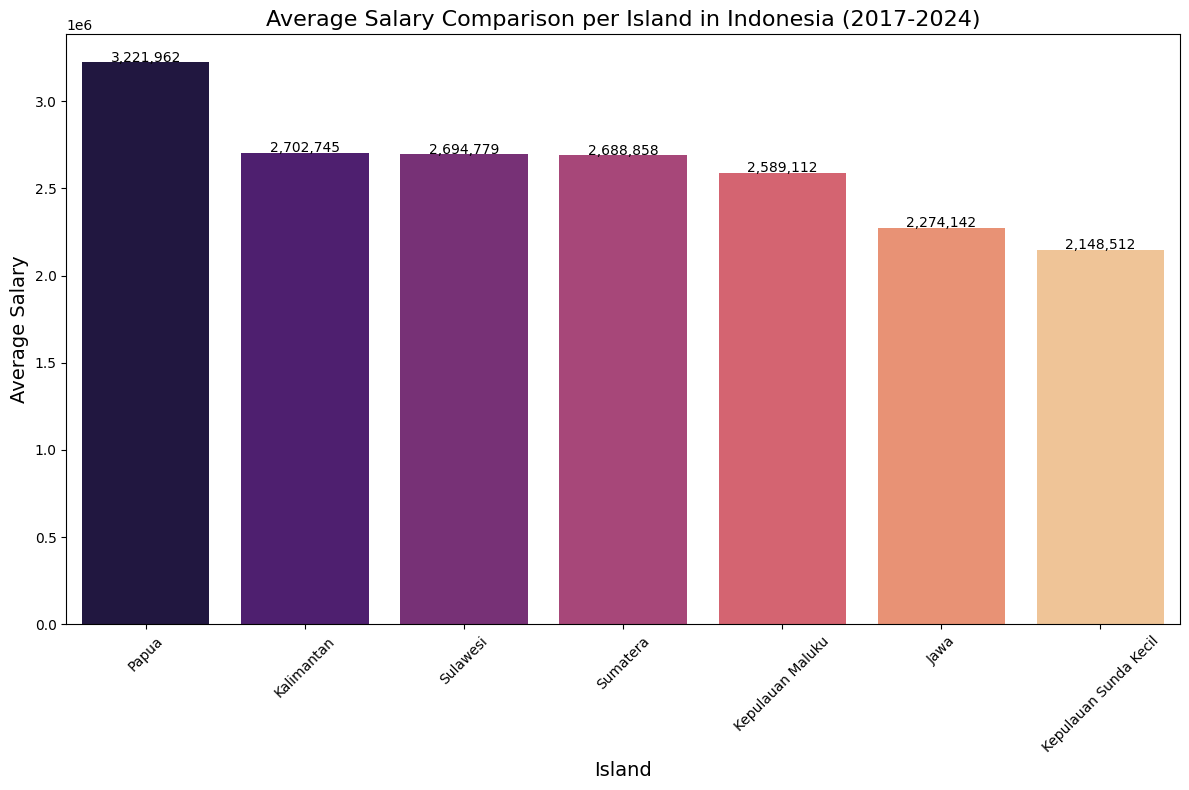

In [170]:
# Calculate the average salary per island for the years 2017-2022
island_salary_filtered = df_filtered.groupby('ISLAND')['SALARY'].mean().sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x=island_salary_filtered.index, y=island_salary_filtered.values, palette='magma')

# Customize the chart
plt.title('Average Salary Comparison per Island in Indonesia (2017-2024)', fontsize=16)
plt.xlabel('Island', fontsize=14)
plt.ylabel('Average Salary', fontsize=14)
plt.xticks(rotation=45)

# Add salary annotations on bars
for i, v in enumerate(island_salary_filtered.values):
    plt.text(i, v + 5000, f"{int(v):,}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()

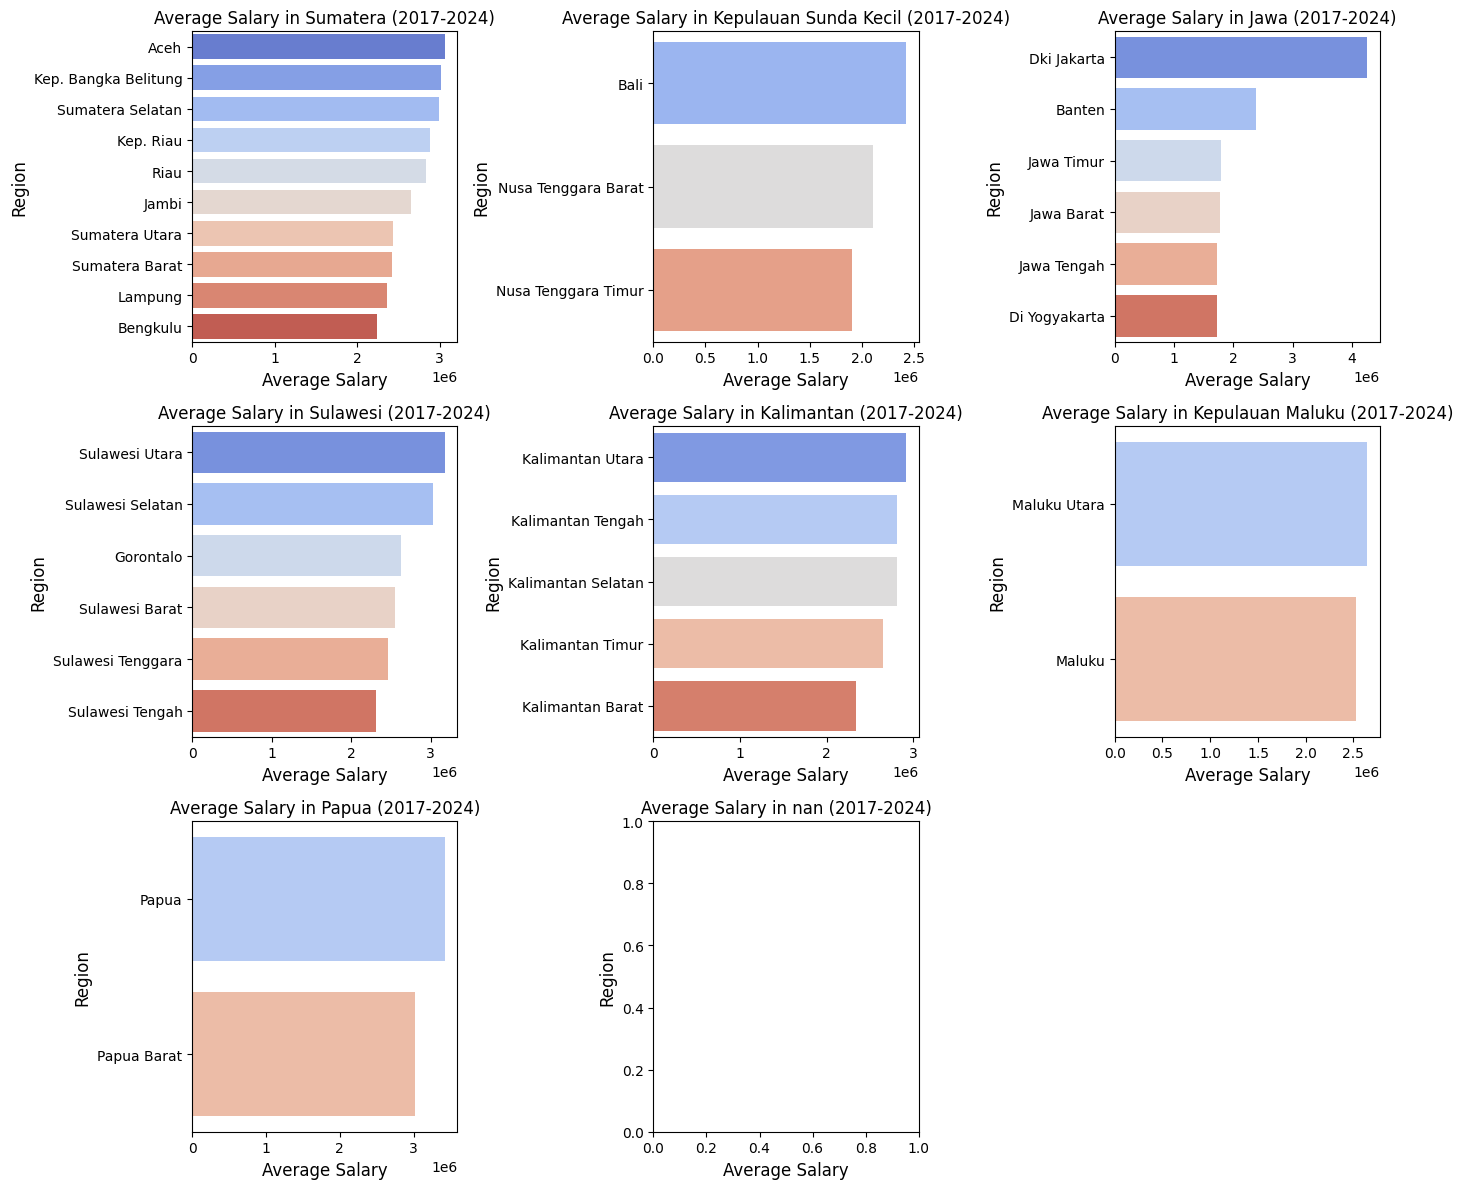

In [178]:
# List of islands to loop through and create individual charts
islands = df_filtered['ISLAND'].unique()

# Create a plot for each island
plt.figure(figsize=(14, 12))
for i, island in enumerate(islands, 1):
    plt.subplot(3, 3, i)  # Create a 3x3 grid for the subplots
    island_data = df_filtered[df_filtered['ISLAND'] == island]

    # Calculate the average salary per region and sort in ascending order
    avg_salary = island_data.groupby('REGION')['SALARY'].mean().sort_values(ascending=False)

    # Plotting the sorted average salary using horizontal barplot
    sns.barplot(y=avg_salary.index, x=avg_salary.values, palette='coolwarm', ci=None)

    plt.title(f'Average Salary in {island} (2017-2024)', fontsize=12)
    plt.xlabel('Average Salary', fontsize=12)
    plt.ylabel('Region', fontsize=12)

plt.tight_layout()
plt.show()

## Modelling

INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8bu98oa3/19q20wlk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp8bu98oa3/rlw_fx1r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94775', 'data', 'file=/tmp/tmp8bu98oa3/19q20wlk.json', 'init=/tmp/tmp8bu98oa3/rlw_fx1r.json', 'output', 'file=/tmp/tmp8bu98oa3/prophet_modelbcownshe/prophet_model-20241116154039.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:40:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:40:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


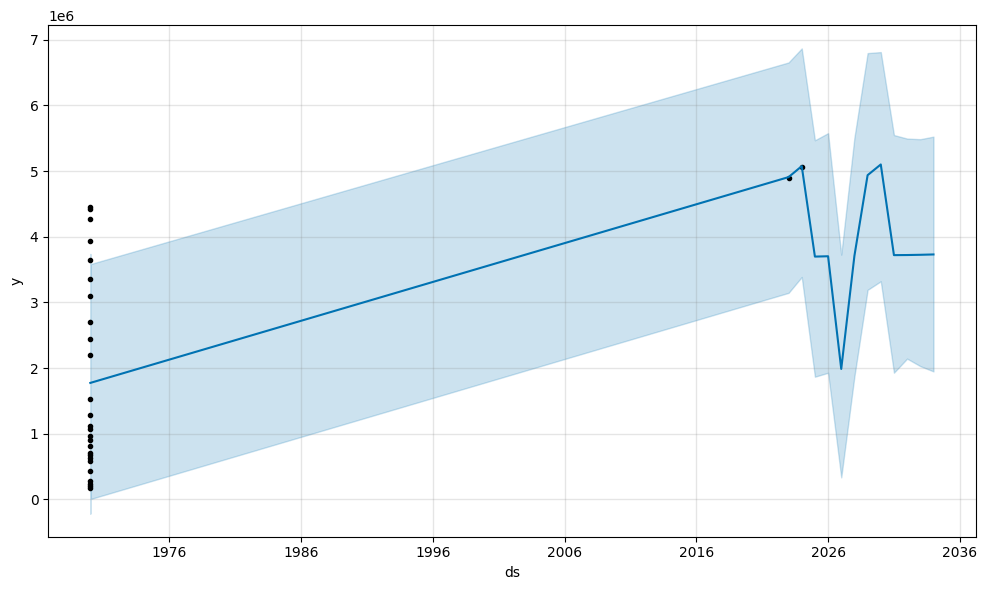

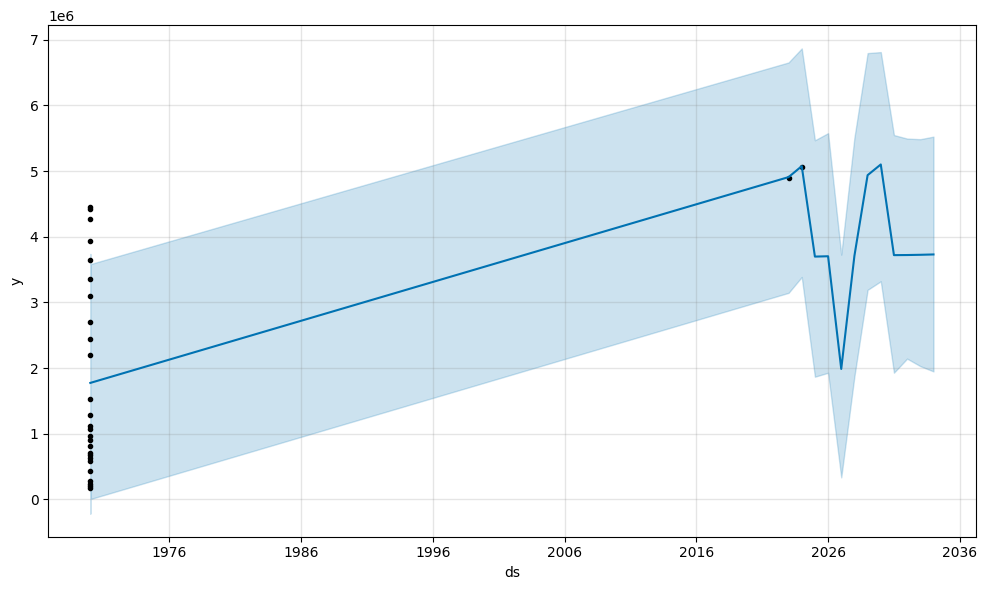

In [182]:
from prophet import Prophet
import pandas as pd

# Assuming your dataframe is `df` and it's in long format
df_prophet = df[df['REGION'] == 'Dki Jakarta']
df_prophet = df_prophet.rename(columns={'YEAR': 'ds', 'SALARY': 'y'})  # Rename columns

# Model for Region 1
model = Prophet()
model.fit(df_prophet)

# Make future dataframe for prediction
future = model.make_future_dataframe(periods=10, freq='Y')  # Predict next 10 years with yearly frequency

# Forecast
forecast = model.predict(future)
model.plot(forecast)

In [ ]:
!pip install scikit-learn pandas numpy
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Misalnya kita punya data X (fitur) dan y (target/UMR)
X = df[['REGION', 'YEAR', 'ISLAND']]  # Ganti dengan fitur yang relevan
y = df['SALARY']  # Target variable (UMR)

# --- Create a OneHotEncoder object ---
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # sparse=False for numpy array output

# --- Fit the encoder on the categorical features and transform them ---
encoded_features = encoder.fit_transform(X[['REGION', 'ISLAND']])

# --- Create a DataFrame from the encoded features ---
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['REGION', 'ISLAND']))

# --- Concatenate the encoded features with the numerical features ---
# --- Convert 'YEAR' to numerical representation ---
X = pd.concat([X['YEAR'].astype(int), encoded_df], axis=1) # Assuming 'YEAR' should be numerical


# Split data ke training dan testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inisialisasi model
model = LinearRegression()

# Training model
model.fit(X_train, y_train)

# Prediksi hasil di data test
y_pred = model.predict(X_test)

# Evaluasi model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

# Tampilkan hasil evaluasi
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataframe is 'df' and it has a 'YEAR' and 'SALARY' column
df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y')

# Filter data for the region you're interested in, for example "Jawa"
df_region = df[df['REGION'] == 'Dki Jakarta']

# Resampling the data to yearly (if not already)
df_region = df_region.groupby('YEAR')['SALARY'].mean()

# Fit ARIMA model (p=1, d=1, q=1 as an example)
model = ARIMA(df_region, order=(1,1,1))
model_fit = model.fit()

# Forecast the next 5 years
forecast = model_fit.forecast(steps=5)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_region, label='Historical Salary')
plt.plot(pd.date_range(df_region.index[-1], periods=6, freq='Y')[1:], forecast, label='Forecast', color='red')
plt.title('Salary Forecast for Jawa Region')
plt.legend()
plt.show()


In [ ]:
import pandas as pd

# Assuming 'df' is your dataframe
df['YEAR'] = pd.to_datetime(df['YEAR'], format='%Y')

# Filter data for the years 2017-2022 (to avoid the issue with different UMR across years)
df_filtered = df[(df['YEAR'].dt.year >= 2017) & (df['YEAR'].dt.year <= 2022)]

# Group by REGION and YEAR to get the average salary per year for each region
df_region_avg_salary = df_filtered.groupby(['REGION', 'YEAR'])['SALARY'].mean().reset_index()


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Dictionary to store forecasts for each region
region_forecasts = {}

# Loop over each unique region
for region in df_region_avg_salary['REGION'].unique():
    # Filter data for the specific region
    region_data = df_region_avg_salary[df_region_avg_salary['REGION'] == region]

    # Set 'YEAR' as index
    region_data.set_index('YEAR', inplace=True)

    # Fit ARIMA model (p=1, d=1, q=1 as a default example)
    model = ARIMA(region_data['SALARY'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast next 5 years (for example, forecasting 2023-2027)
    forecast = model_fit.forecast(steps=5)

    # Store the forecasted values along with the region name
    forecast_dates = pd.date_range(start=region_data.index[-1] + pd.DateOffset(years=1), periods=5, freq='Y')
    forecast_df = pd.DataFrame({'YEAR': forecast_dates, 'REGION': region, 'FORECAST_SALARY': forecast})

    region_forecasts[region] = forecast_df


In [ ]:
# Combine all forecasts into one DataFrame
forecast_df_all_regions = pd.concat(region_forecasts.values(), ignore_index=True)

# Display the combined forecasts for all regions
print(forecast_df_all_regions.head())


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

# Loop through each region and plot the forecasted salaries
for region in df_region_avg_salary['REGION'].unique():
    # Filter historical data for the region
    region_data = df_region_avg_salary[df_region_avg_salary['REGION'] == region]

    # Filter forecasted data for the region
    region_forecast = forecast_df_all_regions[forecast_df_all_regions['REGION'] == region]

    # Plot historical data
    plt.plot(region_data['YEAR'], region_data['SALARY'], label=f'{region} Historical', linestyle='--')

    # Plot forecasted data
    plt.plot(region_forecast['YEAR'], region_forecast['FORECAST_SALARY'], label=f'{region} Forecast', marker='o')

plt.title('Salary Forecast for Each Region (2017-2027)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Salary', fontsize=14)
plt.xticks(rotation=45)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Step 1: Train-Test Split (Assuming 2017-2021 for training, 2022 for testing)
train_data = df_region_avg_salary[df_region_avg_salary['YEAR'].dt.year <= 2021]
test_data = df_region_avg_salary[df_region_avg_salary['YEAR'].dt.year == 2022]

# Dictionary to store evaluation metrics
evaluation_metrics = {}

# Step 2: Fit ARIMA on training data and make predictions for 2022
for region in df_region_avg_salary['REGION'].unique():
    # Filter train and test data for the specific region
    train_region_data = train_data[train_data['REGION'] == region]
    test_region_data = test_data[test_data['REGION'] == region]

    # Set 'YEAR' as index
    train_region_data.set_index('YEAR', inplace=True)

    # Fit ARIMA model (p=1, d=1, q=1)
    model = ARIMA(train_region_data['SALARY'], order=(1, 1, 1))
    model_fit = model.fit()

    # Forecast for 2022 (1 step ahead)
    forecast_2022 = model_fit.forecast(steps=1)

    # Actual salary in 2022 for comparison
    actual_2022 = test_region_data['SALARY'].values[0]

    # Step 3: Calculate evaluation metrics
    mae = mean_absolute_error([actual_2022], forecast_2022)
    mse = mean_squared_error([actual_2022], forecast_2022)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error([actual_2022], forecast_2022)

    # Store the metrics
    evaluation_metrics[region] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape
    }

# Convert the metrics to a DataFrame for better readability
evaluation_df = pd.DataFrame(evaluation_metrics).T
print(evaluation_df)


In [ ]:
from sklearn.linear_model import LinearRegression # Import the LinearRegression class

df= df.reset_index(drop=True).groupby('REGION').apply(lambda x: x.sort_values('YEAR'))

models = {}
for provinsi in df['REGION'].unique():
    X = df.loc[df['REGION'] == provinsi]['YEAR'].values.reshape(-1, 1)
    y = df.loc[df['REGION'] == provinsi]['SALARY'].values.reshape(-1, 1)
    model = LinearRegression().fit(X, y)
    models[provinsi] = model

In [ ]:
future_years = np.array(range(df['YEAR'].max() + 1, df['YEAR'].max() + 11))
future_ump = []
for provinsi in df['REGION'].unique():
    model = models[provinsi]
    future_ump_provinsi = model.predict(future_years.reshape(-1, 1))
    future_ump.extend(future_ump_provinsi)

In [ ]:
future_df = pd.DataFrame({
    'REGION': np.repeat(df['REGION'].unique(), 10),
    'YEAR': np.tile(range(df['YEAR'].max() + 1, df['YEAR'].max() + 11), df['REGION'].nunique()),
    'SALARY': future_ump
})

In [ ]:
future_df['SALARY'] = future_df['SALARY'].astype(int)
future_df.info()

In [ ]:
future_df

## Evaluasi dan Visualisasi

## Konversi Model

## Inference (Optional)